# CNN 모델을 사용한 개와 고양이 이미지 분류하기

데이터 증식 사용하기
* 글자는 X

## 데이터 준비하기

### Colab을 이용 - Google api를 통해 데이터 불러오기

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2023-08-14 06:25:19--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.125.128, 142.250.136.128, 142.250.148.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   284MB/s    in 0.2s    

2023-08-14 06:25:20 (284 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



### 데이터 폴더 나누기

In [ ]:
# 압축풀기
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
# 데이터 경로 설정
rootPath = '/tmp/cats_and_dogs_filtered'

# 훈련셋, 검증셋 경로
train_dir = os.path.join(rootPath, 'train') # /tmp/cats_and_dogs_filtered/train
validation_dir = os.path.join(rootPath, 'validation')  # /tmp/cats_and_dogs_filtered/validation

# 훈련셋 중에 고양이 사진 경로
train_cats_dir = os.path.join(train_dir, 'cats') # /tmp/cats_and_dogs_filtered/train/cats
# 훈련셋 중에 강아지 사진 경로
train_dogs_dir = os.path.join(train_dir, 'dogs') # /tmp/cats_and_dogs_filtered/train/dogs


# 검증셋 중에 고양이 사진 경로
validation_cats_dir = os.path.join(validation_dir, 'cats') # /tmp/cats_and_dogs_filtered/validation/cats
# 검증셋 중에 강아지 사진 경로
validation_dogs_dir = os.path.join(validation_dir, 'dogs') # /tmp/cats_and_dogs_filtered/validation/dogs

## 데이터 확인하기

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
train_cat_fnames.sort()
#print(train_cat_fnames[:10])

print('훈련 데이터 중 고양이 사진 수 : ', len(os.listdir(train_cats_dir)))
print('훈련 데이터 중 강아지 사진 수 : ', len(os.listdir(train_dogs_dir)))

print('검증 데이터 중 고양이 사진 수 : ', len(os.listdir(validation_cats_dir)))
print('검증 데이터 중 강아지 사진 수 : ', len(os.listdir(validation_dogs_dir)))

훈련 데이터 중 고양이 사진 수 :  1000
훈련 데이터 중 강아지 사진 수 :  1000
검증 데이터 중 고양이 사진 수 :  500
검증 데이터 중 강아지 사진 수 :  500


## 데이터 증식 (Data Argumentation)

In [ ]:
import os
from keras.preprocessing.image import ImageDataGenerator

# 데이터 경로 설정
rootPath = '/tmp/cats_and_dogs_filtered'

# 스케일링 + 데이터 증식 속성 설정
trainImageGenerator = ImageDataGenerator(rescale=1./255,
                                         horizontal_flip = True,
                                         vertical_flip = True,
                                         shear_range = 0.5,
                                         brightness_range = [0.5, 1.5],
                                         zoom_range = 0.2,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         rotation_range = 30,
                                         fill_mode = 'nearest')

# 스케일링 설정
testImageGenerator =  ImageDataGenerator(rescale=1./255)

# 데이터 스케일링 및 증식
trainGen = trainImageGenerator.flow_from_directory(
    os.path.join(rootPath, 'train'),
    target_size=(64, 64),
    class_mode = 'binary'
)

testGen = testImageGenerator.flow_from_directory(
    os.path.join(rootPath, 'validation'),
    target_size=(64, 64),
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
print(trainGen.class_indices)
print(testGen.class_indices)

{'cats': 0, 'dogs': 1}
{'cats': 0, 'dogs': 1}


## 이미지 그려보기

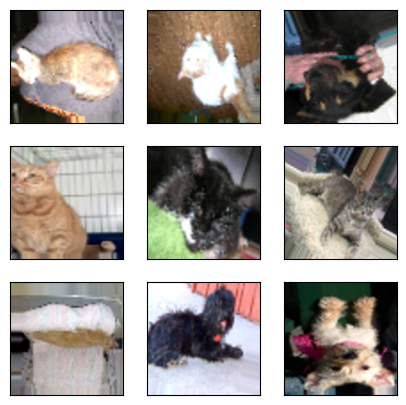

In [ ]:
from tensorflow.keras.preprocessing.image import array_to_img
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5, 5))

for i in range(9):
  data = next(trainGen)
  arr = data[0][0]
  plt.subplot(3, 3, i+1)
  plt.xticks([]) # 눈금 지우기
  plt.yticks([])
  img = array_to_img(arr).resize((128, 128))
  plt.imshow(img)

plt.show()

사진 : ['dogs']
사진 : 1


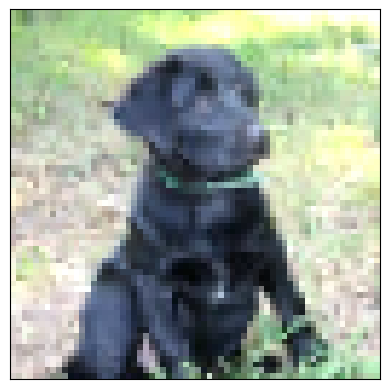

사진 : ['cats']
사진 : 0


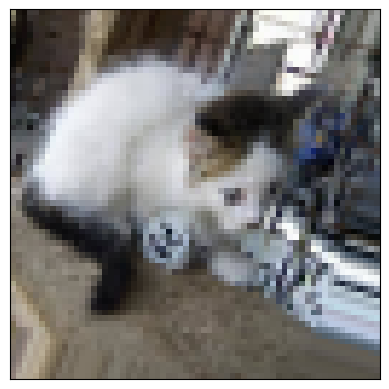

사진 : ['cats']
사진 : 0


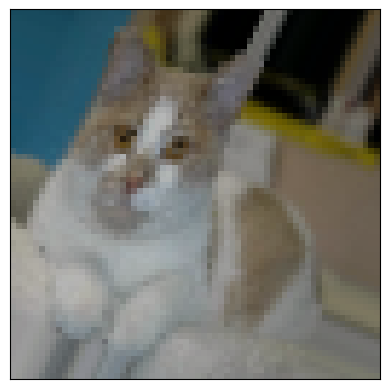

In [ ]:
label_index = trainGen.class_indices

# {'cats': 0, 'dogs': 1}
x, y = trainGen.next()

for i in range(0, 3):
  image = x[i]
  label = y[i].astype('int')
  plt.xticks([]) # 눈금 지우기
  plt.yticks([])
  print('사진 : {}'.format([k for k, v in label_index.items() if v == label]))
  print('사진 : {}'.format(label))
  plt.imshow(image)
  plt.show()

## 간단한 CNN 모델 구성

In [ ]:
from keras.models import Sequential
from keras import layers

model = Sequential()

model.add(layers.InputLayer(input_shape=(64, 64, 3)))


model.add(layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 32, 32, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 16, 16, 32)       

## 모델 설정하기

In [ ]:
model.compile(optimizer='adam', loss ='binary_crossentropy', metrics=['acc'])

## 모델 학습하기

In [ ]:
history =model.fit(trainGen, epochs = 64, validation_data= testGen)

Epoch 1/64
63/63 [==============================] - 18s 114ms/step - loss: 0.7226 - acc: 0.5045 - val_loss: 0.6934 - val_acc: 0.4980
Epoch 2/64
63/63 [==============================] - 8s 123ms/step - loss: 0.6928 - acc: 0.5175 - val_loss: 0.6880 - val_acc: 0.5930
Epoch 3/64
63/63 [==============================] - 7s 107ms/step - loss: 0.6845 - acc: 0.5580 - val_loss: 0.6875 - val_acc: 0.5440
Epoch 4/64
63/63 [==============================] - 7s 108ms/step - loss: 0.6731 - acc: 0.5895 - val_loss: 0.6633 - val_acc: 0.6000
Epoch 5/64
63/63 [==============================] - 8s 122ms/step - loss: 0.6631 - acc: 0.6145 - val_loss: 0.6543 - val_acc: 0.6100
Epoch 6/64
63/63 [==============================] - 8s 122ms/step - loss: 0.6721 - acc: 0.5770 - val_loss: 0.6630 - val_acc: 0.6230
Epoch 7/64
63/63 [==============================] - 7s 108ms/step - loss: 0.6421 - acc: 0.6395 - val_loss: 0.6466 - val_acc: 0.6070
Epoch 8/64
63/63 [==============================] - 8s 123ms/step - loss: 0

## 학습 결과 분석

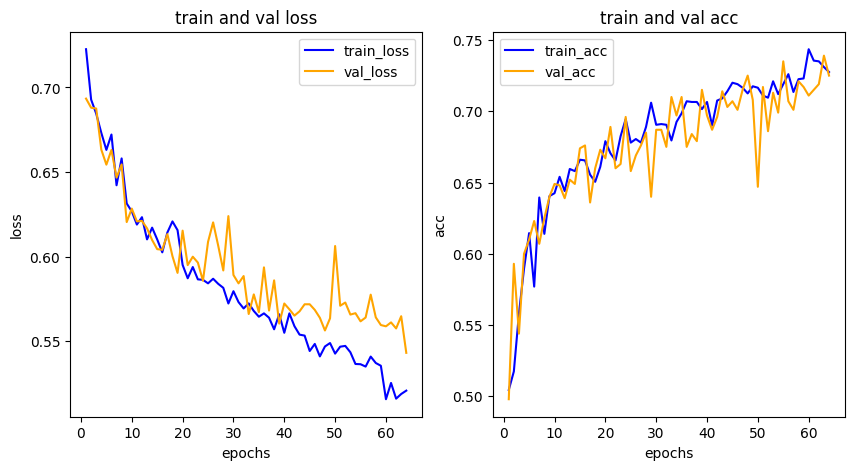

In [ ]:
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

## 모델 평가하기

In [ ]:
model.evaluate(testGen)

32/32 [==============================] - 2s 66ms/step - loss: 0.5431 - acc: 0.7250


[0.5430505871772766, 0.7250000238418579]

1/1 [==============================] - 0s 23ms/step
정답: 강아지  label : 1
예측: 고양이  predicted value : [[0.46033454]]


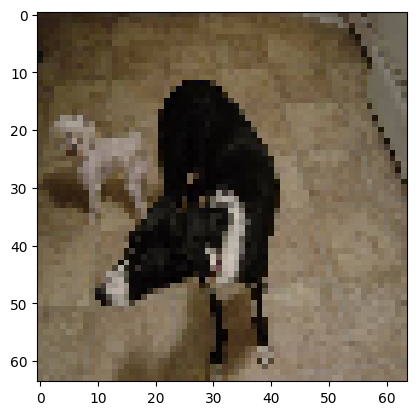

1/1 [==============================] - 0s 21ms/step
정답: 강아지  label : 1
예측: 강아지  predicted value : [[0.9702178]]


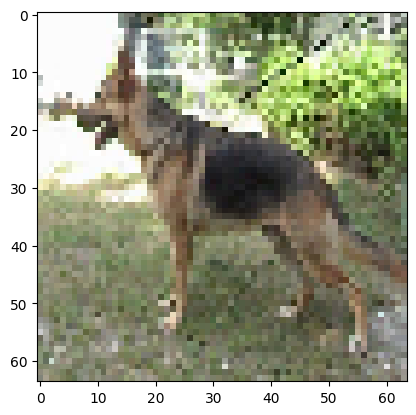

1/1 [==============================] - 0s 18ms/step
정답: 고양이  label : 0
예측: 고양이  predicted value : [[0.3075826]]


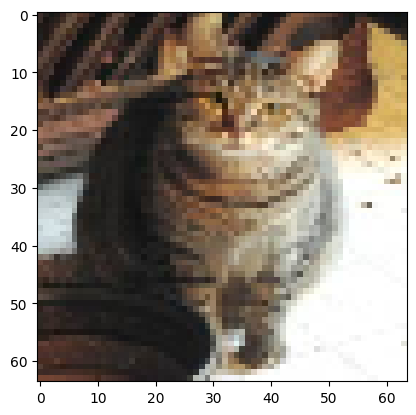

In [ ]:
from tensorflow.keras.preprocessing.image import array_to_img
import numpy as np

label_index = ['고양이', '강아지']

x, y = testGen.next()
for i in range(0,3):
  image = x[i]
  label = y[i].astype('int')

  y_prob = model.predict(image.reshape(1, 64, 64, 3))
  y_prob_class = (model.predict(image.reshape(1, 64, 64, 3)) > 0.5 ).astype('int')[0][0]
  print('정답: {}'.format(label_index[label]), ' label :', label)
  print('예측: {}'.format(label_index[y_prob_class]), ' predicted value :', y_prob)
  plt.imshow(image)
  plt.show()

## 사전학습 모델을 활용해서 예측 정확도 올리기

*   학습데이터, 테스트 데이터 그대로 사용
*   첫번째 모델 VGG16 사용 + GlobalAveragerPooling2D() + Flatten() + Dense(256) + Dense(64) + Dense(1)
*   두번째 모델 ResNet50V 사용 + GlobalAveragerPooling2D() + Flatten() + Dense(256) + Dense(64) + Dense(1)
*    두개의 모델 성능을 비교



### 정확도가 높은 분류 모델 구성 - 전이학습 모델 (VGG16 사용)



#### 모델 구성하기

In [ ]:
from keras.models import Sequential
from keras.applications import VGG16
from keras.layers import Conv2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.optimizers import Adam

# 전이학습 모델 가져오기
pre_trained_vgg = VGG16(input_shape=(64,64,3), include_top=False, weights='imagenet')
pre_trained_vgg.summary()

# 분류모델 합치기
model_vgg = Sequential()
model_vgg.add(pre_trained_vgg)
model_vgg.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))  # VGG16을 Conv2D로 수정
model_vgg.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))  # VGG16을 Conv2D로 수정
model_vgg.add(GlobalAveragePooling2D())
model_vgg.add(Dropout(0.1))

model_vgg.add(Flatten())
model_vgg.add(Dense(256, activation='relu'))
model_vgg.add(Dense(64, activation='relu'))
model_vgg.add(Dense(1, activation='sigmoid'))  # 10개가 아니라 2개(0 또는 1)의 출력을 가지는 신경망입니다.

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

#### 모델 설정 및 학습하기

In [ ]:
model_vgg.compile(optimizer = Adam(1e-4), # 러닝레이트를 정해줌
             loss = 'binary_crossentropy', #원-핫 인코딩 사용하지 않는 경우 (0-9 레이블 그대로 사용하는 경우)
             metrics = ['acc'])

history =model_vgg.fit(trainGen, epochs = 64, validation_data= testGen)

Epoch 1/64
63/63 [==============================] - 10s 143ms/step - loss: 0.6901 - acc: 0.5315 - val_loss: 0.6997 - val_acc: 0.5000
Epoch 2/64
63/63 [==============================] - 8s 121ms/step - loss: 0.6936 - acc: 0.4990 - val_loss: 0.6911 - val_acc: 0.5000
Epoch 3/64
63/63 [==============================] - 9s 134ms/step - loss: 0.6898 - acc: 0.5345 - val_loss: 0.6939 - val_acc: 0.5000
Epoch 4/64
63/63 [==============================] - 8s 134ms/step - loss: 0.6911 - acc: 0.5455 - val_loss: 0.7043 - val_acc: 0.5000
Epoch 5/64
63/63 [==============================] - 8s 123ms/step - loss: 0.6850 - acc: 0.5615 - val_loss: 0.7096 - val_acc: 0.5310
Epoch 6/64
63/63 [==============================] - 10s 156ms/step - loss: 0.6890 - acc: 0.5380 - val_loss: 0.7155 - val_acc: 0.5030
Epoch 7/64
63/63 [==============================] - 9s 136ms/step - loss: 0.6814 - acc: 0.5650 - val_loss: 0.6782 - val_acc: 0.5660
Epoch 8/64
63/63 [==============================] - 8s 129ms/step - loss: 

#### VGG16 학습 결과 분석

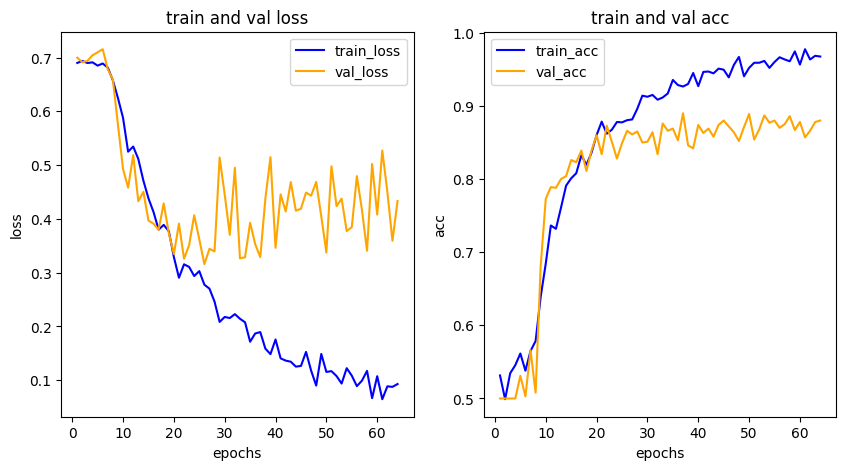

In [ ]:
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

#### VGG16 모델 평가하기

In [ ]:
model_vgg.evaluate(testGen)

32/32 [==============================] - 2s 48ms/step - loss: 0.4333 - acc: 0.8800


[0.43332672119140625, 0.8799999952316284]

### 정확도가 높은 분류 모델 구성 - 전이학습 모델 (ResNet50V2 사용)



#### 모델 구성하기

In [ ]:
from keras.models import Sequential
from keras.applications import ResNet50V2
from keras.layers import Conv2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.optimizers import Adam

# 전이학습 모델 가져오기
pre_trained_res = ResNet50V2(input_shape=(64,64,3), include_top=False, weights='imagenet')
pre_trained_res.summary()

# 분류모델 합치기
model_res = Sequential()
model_res.add(pre_trained_vgg)
model_res.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model_res.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model_res.add(GlobalAveragePooling2D())
model_res.add(Dropout(0.1))

model_res.add(Flatten())
model_res.add(Dense(256, activation='relu'))
model_res.add(Dense(64, activation='relu'))
model_res.add(Dense(1, activation='sigmoid'))  # 10개가 아니라 2개(0 또는 1)의 출력을 가지는 신경망입니다.

94668760/94668760 [==============================] - 0s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_21[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 34, 34, 64)   0           ['conv1_conv[0][0]']             
                        

#### 모델 설정 및 학습하기

In [ ]:
model_res.compile(optimizer = Adam(1e-4), # 러닝레이트를 정해줌
             loss = 'binary_crossentropy', #원-핫 인코딩 사용하지 않는 경우 (0-9 레이블 그대로 사용하는 경우)
             metrics = ['acc'])

history1 =model_res.fit(trainGen, epochs = 64, validation_data= testGen)

Epoch 1/64
63/63 [==============================] - 93s 143ms/step - loss: 0.1462 - acc: 0.9455 - val_loss: 0.4406 - val_acc: 0.8780
Epoch 2/64
63/63 [==============================] - 9s 138ms/step - loss: 0.0846 - acc: 0.9680 - val_loss: 0.4129 - val_acc: 0.8890
Epoch 3/64
63/63 [==============================] - 8s 123ms/step - loss: 0.0823 - acc: 0.9675 - val_loss: 0.4336 - val_acc: 0.8830
Epoch 4/64
63/63 [==============================] - 9s 138ms/step - loss: 0.0810 - acc: 0.9725 - val_loss: 0.3600 - val_acc: 0.8720
Epoch 5/64
63/63 [==============================] - 9s 141ms/step - loss: 0.0638 - acc: 0.9785 - val_loss: 0.6299 - val_acc: 0.8710
Epoch 6/64
63/63 [==============================] - 8s 123ms/step - loss: 0.0717 - acc: 0.9705 - val_loss: 0.5925 - val_acc: 0.8940
Epoch 7/64
63/63 [==============================] - 8s 124ms/step - loss: 0.0878 - acc: 0.9705 - val_loss: 0.6113 - val_acc: 0.8660
Epoch 8/64
63/63 [==============================] - 9s 137ms/step - loss: 0

#### 학습 결과 분석

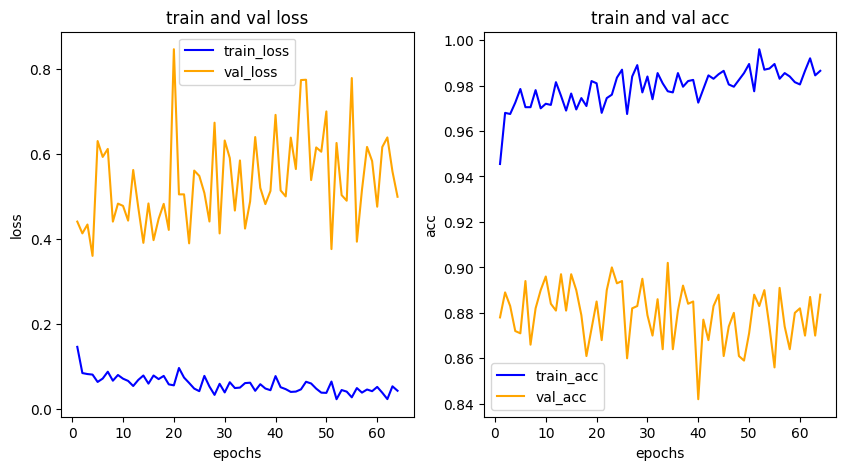

In [ ]:
import matplotlib.pyplot as plt

his_dict = history1.history
loss = his_dict['loss']
val_loss = his_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

#### 모델 평가하기

In [ ]:
model_res.evaluate(testGen)

32/32 [==============================] - 2s 63ms/step - loss: 0.4989 - acc: 0.8880


[0.4988793134689331, 0.8880000114440918]

#### 두 모델 비교하기

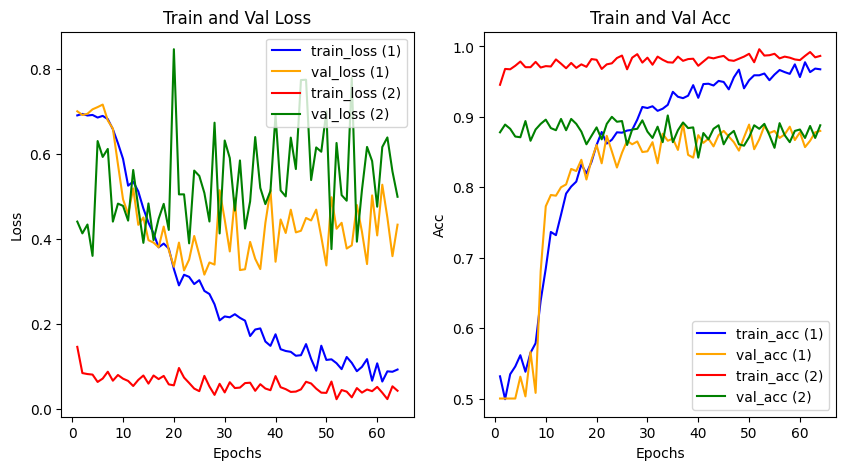

In [ ]:
import matplotlib.pyplot as plt

# 첫 번째 히스토리
his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss']
acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 두 번째 히스토리
his_dict1 = history1.history
loss1 = his_dict1['loss']
val_loss1 = his_dict1['val_loss']
acc1 = his_dict1['acc']
val_acc1 = his_dict1['val_acc']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color='blue', label='train_loss (1)')
ax1.plot(epochs, val_loss, color='orange', label='val_loss (1)')
ax1.plot(epochs, loss1, color='red', label='train_loss (2)')
ax1.plot(epochs, val_loss1, color='green', label='val_loss (2)')
ax1.set_title('Train and Val Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color='blue', label='train_acc (1)')
ax2.plot(epochs, val_acc, color='orange', label='val_acc (1)')
ax2.plot(epochs, acc1, color='red', label='train_acc (2)')
ax2.plot(epochs, val_acc1, color='green', label='val_acc (2)')
ax2.set_title('Train and Val Acc')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Acc')
ax2.legend()

plt.show()


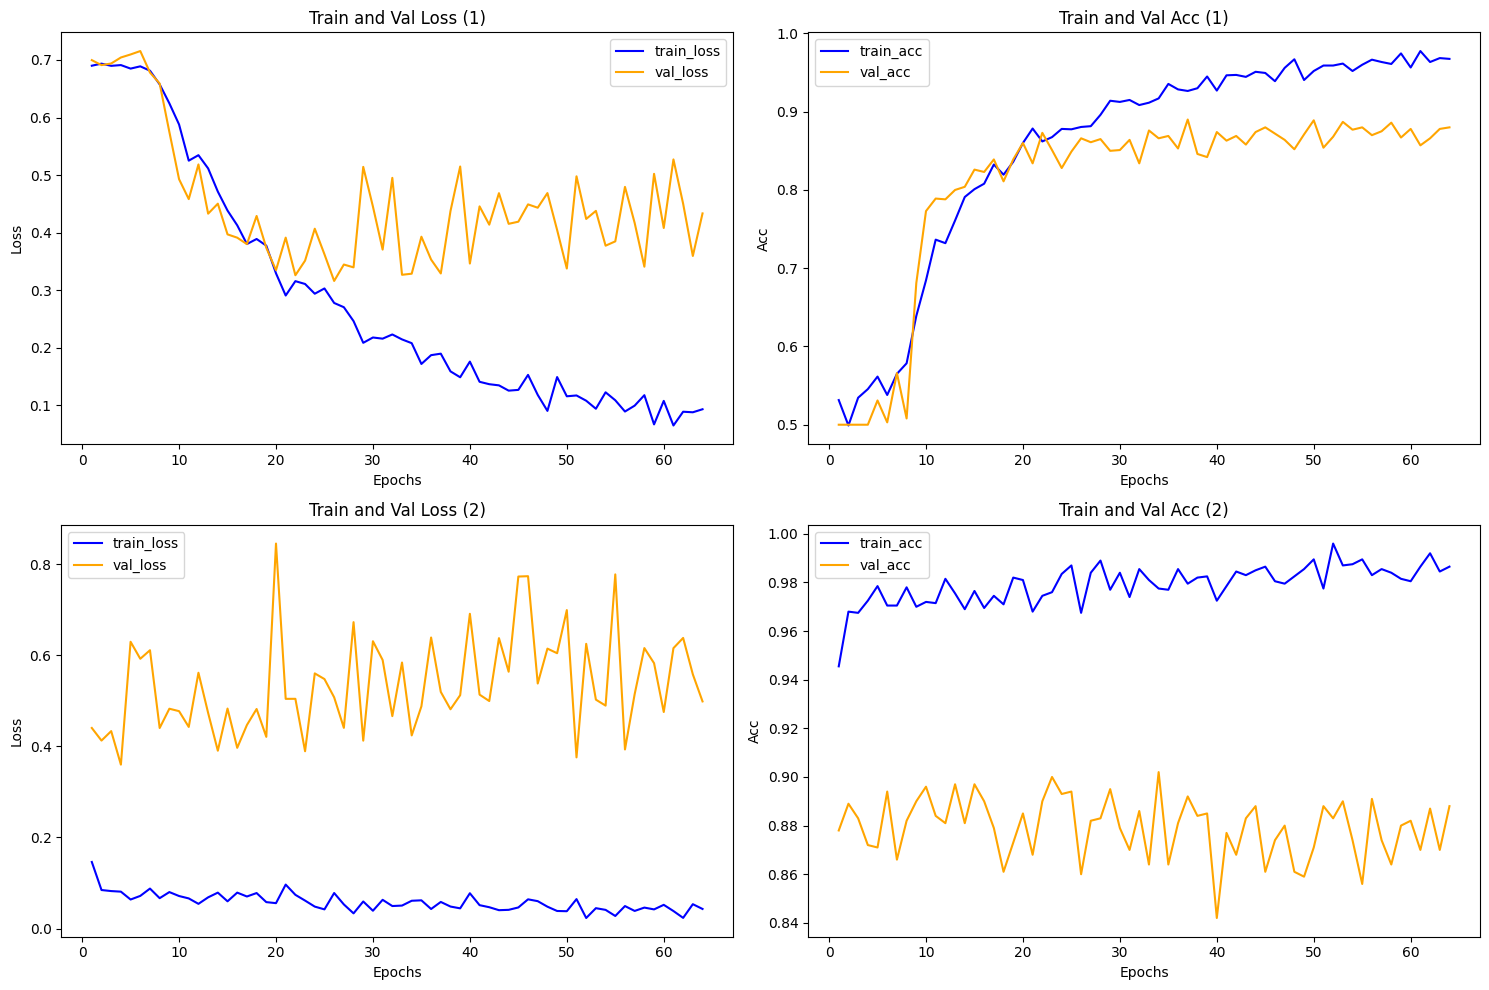

In [ ]:
import matplotlib.pyplot as plt

# 첫 번째 히스토리
his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss']
acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 두 번째 히스토리
his_dict1 = history1.history
loss1 = his_dict1['loss']
val_loss1 = his_dict1['val_loss']
acc1 = his_dict1['acc']
val_acc1 = his_dict1['val_acc']

epochs = range(1, len(loss) + 1)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 첫 번째 히스토리 - 훈련 및 검증 손실 그리기
axes[0, 0].plot(epochs, loss, color='blue', label='train_loss')
axes[0, 0].plot(epochs, val_loss, color='orange', label='val_loss')
axes[0, 0].set_title('Train and Val Loss (1)')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# 첫 번째 히스토리 - 훈련 및 검증 정확도 그리기
axes[0, 1].plot(epochs, acc, color='blue', label='train_acc')
axes[0, 1].plot(epochs, val_acc, color='orange', label='val_acc')
axes[0, 1].set_title('Train and Val Acc (1)')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Acc')
axes[0, 1].legend()

# 두 번째 히스토리 - 훈련 및 검증 손실 그리기
axes[1, 0].plot(epochs, loss1, color='blue', label='train_loss')
axes[1, 0].plot(epochs, val_loss1, color='orange', label='val_loss')
axes[1, 0].set_title('Train and Val Loss (2)')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

# 두 번째 히스토리 - 훈련 및 검증 정확도 그리기
axes[1, 1].plot(epochs, acc1, color='blue', label='train_acc')
axes[1, 1].plot(epochs, val_acc1, color='orange', label='val_acc')
axes[1, 1].set_title('Train and Val Acc (2)')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Acc')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


In [ ]:
# VGG 모델 정확도
model_vgg.evaluate(testGen)

32/32 [==============================] - 2s 52ms/step - loss: 0.4790 - acc: 0.8930


[0.479013592004776, 0.8930000066757202]

In [ ]:
# ResNet 모델 정확도
model_res.evaluate(testGen)

32/32 [==============================] - 2s 46ms/step - loss: 0.4989 - acc: 0.8880


[0.4988793134689331, 0.8880000114440918]